## チュートリアル（処理済み検索ログを使う場合）

In [3]:
# ========================================
# Library
# ========================================
import math
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

In [4]:
train_df = pd.read_csv('train/train.csv')
road_df = pd.read_csv('train/road_local.csv')
search_spec_df = pd.read_csv('train/search_specified.csv')
search_unspec_df = pd.read_csv('train/search_unspecified.csv')

In [5]:
def expand_datetime(df):
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    return df

In [6]:
def extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
    search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])

    train_df = expand_datetime(train_df)
    search_unspec_df = expand_datetime(search_unspec_df)

    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['year', 'month', 'day', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(road_df.drop(['start_name', 'end_name'], axis=1), on=['start_code', 'end_code'], how='left')

    train_df['dayofweek'] = train_df['datetime'].dt.weekday

    return train_df

In [7]:
train = extract_dataset(train_df, search_spec_df, search_unspec_df)

In [8]:
train['section'] = train['start_code'].astype(str) + '_' + train['KP'].astype(str) + '_' + train['end_code'].astype(str)

In [9]:
cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'hour', 'dayofweek']
num_cols = ['year', 'month', 'day', 'hour', 'search_specified', 'search_unspecified', 'KP', 'start_KP', 'end_KP', 'limit_speed']
feature_cols = cat_cols + num_cols

In [10]:
train[feature_cols]

,road_code,start_code,end_code,section,direction,hour,dayofweek,year,month,day,hour,search_specified,search_unspecified,KP,start_KP,end_KP,limit_speed
0,1800,1110210,1800006,1110210_2.48_1800006,下り,0,3,2021,4,8,0,15.0,3419.0,2.480,0.8,9.4,100.0
1,1800,1110210,1800006,1110210_2.48_1800006,下り,1,3,2021,4,8,1,6.0,3419.0,2.480,0.8,9.4,100.0
2,1800,1110210,1800006,1110210_2.48_1800006,下り,2,3,2021,4,8,2,3.0,3419.0,2.480,0.8,9.4,100.0
3,1800,1110210,1800006,1110210_2.48_1800006,下り,3,3,2021,4,8,3,26.0,3419.0,2.480,0.8,9.4,100.0
4,1800,1110210,1800006,1110210_2.48_1800006,下り,4,3,2021,4,8,4,30.0,3419.0,2.480,0.8,9.4,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5800075,1040,1040126,1040121,1040126_168.082_1040121,上り,19,0,2023,7,31,19,14.0,1989.0,168.082,169.7,160.5,100.0
5800076,1040,1040126,1040121,1040126_168.082_1040121,上り,20,0,2023,7,31,20,18.0,1989.0,168.082,169.7,160.5,100.0
5800077,1040,1040126,1040121,1040126_168.082_1040121,上り,21,0,2023,7,31,21,24.0,1989.0,168.082,169.7,160.5,100.0
5800078,1040,1040126,1040121,1040126_168.082_1040121,上り,22,0,2023,7,31,22,15.0,1989.0,168.082,169.7,160.5,100.0


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5800080 entries, 0 to 5800079
Data columns (total 30 columns):
 #   Column              Dtype         
---  ------              -----         
 0   datetime            datetime64[ns]
 1   start_code          int64         
 2   end_code            int64         
 3   KP                  float64       
 4   OCC                 float64       
 5   allCars             int64         
 6   speed               float64       
 7   is_congestion       int64         
 8   year                int32         
 9   month               int32         
 10  day                 int32         
 11  hour                int32         
 12  search_specified    float64       
 13  date                datetime64[ns]
 14  search_unspecified  float64       
 15  road_code           int64         
 16  direction           object        
 17  limit_speed         float64       
 18  start_KP            float64       
 19  end_KP              float64       
 20  st

In [12]:
# ========================================
# カテゴリ変数の処理
# ========================================
le_dict = {}
for c in tqdm(cat_cols):
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])
    le_dict[c] = le

# with open("../src/features/le_dict.pkl", "wb") as f:
#     pickle.dump(le_dict, f)

100%|██████████| 7/7 [00:03<00:00,  1.99it/s]


In [13]:
# ========================================
# training module
# ========================================
def train_lgbm(X,
               y,
               cv,
               model_path = [],
               params: dict=None,
               verbose: int=100
               ):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}
    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]


        clf = lgb.LGBMClassifier(**params)

        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                early_stopping_rounds=50,
                verbose=verbose,
                )

        pred_i = clf.predict_proba(x_valid)[:,1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = roc_auc_score(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = roc_auc_score(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: CV Score: {score:.4f}")
    return score, oof_pred, models

In [1]:
# ========================================
# parameters
# ========================================
params = {
    "objective": "binary",
    "metric": "auc",
    "n_estimators": 100000,
    "learning_rate": 0.1,
    "importance_type": "gain",
    "random_state": 42,
    "verbose": -1,
}
# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols].values
y = train[TARGET].values

print('train shape:', train.shape)
# ========================================
# training
# ========================================
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list)

NameError: name 'StratifiedGroupKFold' is not defined

In [15]:
# 最適な閾値を探索

def func(x_list, df, oof):
    score = f1_score(df[TARGET], oof>x_list[0])
    return -score

x0 = [0.5]
result = minimize(func, x0,  args=(train, oof_pred), method="nelder-mead")
threshold = result.x[0]
train['pred'] = (oof_pred>threshold).astype(int)
print('threshold:', threshold)
print(classification_report(train[TARGET], train['pred']))

threshold: 0.09550781249999964
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5779316
           1       0.27      0.32      0.30     20764

    accuracy                           0.99   5800080
   macro avg       0.64      0.66      0.65   5800080
weighted avg       0.99      0.99      0.99   5800080



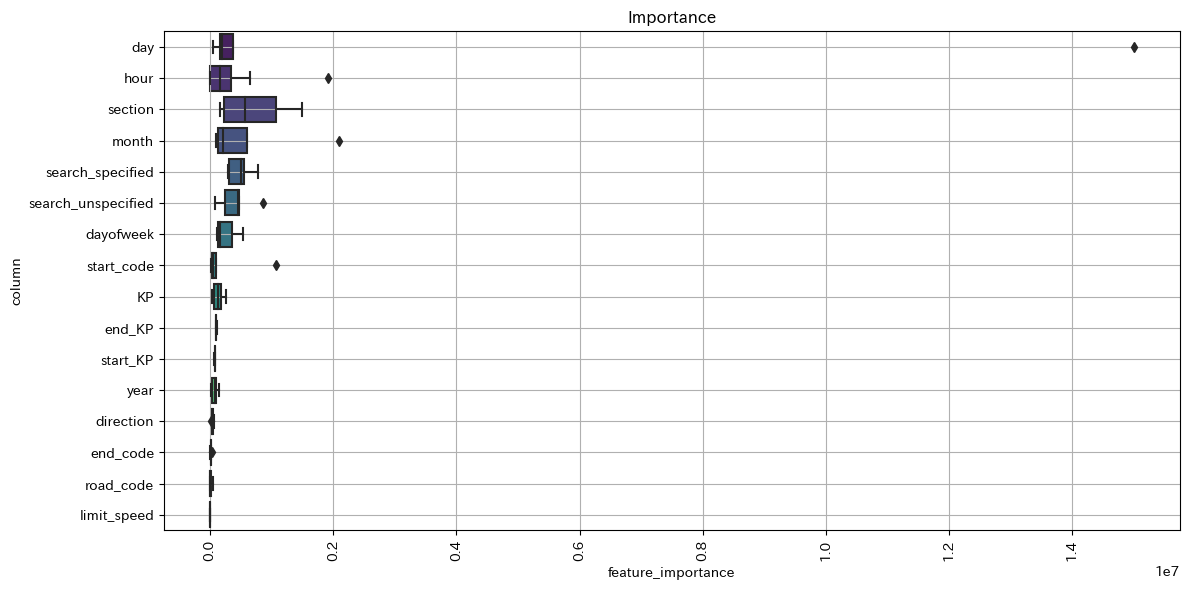

In [16]:
# ========================================
# feature importance
# ========================================
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, train[feature_cols])

# save model


In [17]:
import pickle
# カレントディレクトリへモデルを保存
file = 'sample_submit/model/trained_model.pkl'
pickle.dump(models, open(file, 'wb'))